In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize

In [ ]:
# Input parameters
portfolio_size = 5
# Backtest timeframe
l_threshold = pd.to_datetime("2025-01-02")
u_threshold = pd.to_datetime("2025-05-16")
# last month before buy
check_date = l_threshold - pd.DateOffset(months=1) + pd.offsets.MonthEnd(0)
risk_free_rate = 0.04

In [ ]:
# change the dataframes column names and datatypes
def parse_data(df, exchange_name=""):
    return(
        df.rename(columns={
            "<Ticker>":"ticker",
            '<DTYYYYMMDD>':'date', 
            '<Open>':'open', 
            '<High>':'high', 
            '<Low>':'low', 
            '<Close>':'close',
            '<Volume>':'volume'
        }).assign(
            date = lambda x: pd.to_datetime(x['date'], format="%Y%m%d"),
            exchange = exchange_name
        )
    )

def add_daily_return(df):
    return(
        df.assign(
            daily_return = lambda x: x['close'].pct_change() + 1
        )
    )

def get_rolling_return(df):
    # calculate cummulative return of 3 months, 6 months, and 12 months window
    return_df = pd.DataFrame(df.set_index('date').resample('ME')['daily_return'].prod()).rename(columns={
        'daily_return':'return_1m'
    }).assign(
        return_3m = lambda x: x["return_1m"].rolling(3).apply(np.prod),
        return_6m = lambda x: x["return_1m"].rolling(6).apply(np.prod), 
        return_12m = lambda x: x["return_1m"].rolling(12).apply(np.prod) 
    )
    return return_df

# Return negative Sharpe Ratio
# Since I'm using scipy minimize function, minimize the negative = maximize
def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio

# Make sure portfolio weight sums up to 1
def check_sum(weights):
    return np.sum(weights) - 1

# Function to calculate the annualized Sharpe Ratio
def calculate_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(expected_returns * weights) * 252  # Annualize return, there are 252 trading days in a year
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualize std dev
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return sharpe_ratio

def optimize_portfolio(df, risk_free_rate=0.01):
    # Calculate the expected return for each stock
    expected_returns = df.groupby('ticker')['daily_return'].mean().values - 1
    # Covariance matrix
    cov_matrix = df.pivot_table(values='daily_return', index='date', columns='ticker').pct_change().cov()

    num_assets = len(expected_returns) # number of stocks
    # Assume all stock are weighted equally at first
    initial_weights = np.array([1/num_assets] * num_assets)
    bounds = [(0.1, 1)] * num_assets # 0 < weight < 1
    # Make sure the weights add up to 1
    constraints = ({'type': 'eq', 'fun': check_sum})

    # Optimize weights
    opt_solution = minimize(
        neg_sharpe_ratio, 
        initial_weights,
        args=(expected_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    optimal_weights = opt_solution.x
    sharpe_ratio = calculate_sharpe_ratio(optimal_weights, expected_returns, cov_matrix, risk_free_rate)

    optimal_portfolio = dict(zip(
            df['ticker'].unique(), np.round(optimal_weights, 2)
        ))

    return optimal_portfolio, sharpe_ratio

In [153]:
# Read data
if 'stock_returns.csv' not in os.listdir("data"):
    hnx = parse_data(pd.read_csv(os.path.join('data', "CafeF.HNX.Upto29.05.2025.csv")), exchange_name="HNX")
    hsx = parse_data(pd.read_csv(os.path.join('data', "CafeF.HSX.Upto29.05.2025.csv")), exchange_name= "HOSE")
    upcom = parse_data(pd.read_csv(os.path.join('data', "CafeF.UPCOM.Upto29.05.2025.csv")), exchange_name="UPCOM")
    # Combine all exchanges, calculate daily return
    vnstocks = pd.concat([hnx, hsx, upcom], axis=0)[['ticker', 'date', 'close', "exchange"]] \
        .sort_values(['ticker', "date"], ascending=True, ignore_index=True)\
        .groupby('ticker').apply(add_daily_return)\
        .reset_index(drop=True)
    return_vnstocks = vnstocks.groupby('ticker').apply(get_rolling_return).reset_index()
    vnstocks.to_csv(os.path.join('data', "historical_data.csv"), index=False)
    return_vnstocks.to_csv(os.path.join('data', "stock_returns.csv"), index=False)
else:
    vnstocks = pd.read_csv(os.path.join('data', "historical_data.csv")).assign(
        date = lambda x: pd.to_datetime(x['date'])
    )
    return_vnstocks = pd.read_csv(os.path.join('data', "stock_returns.csv")).assign(
        date = lambda x: pd.to_datetime(x['date'])
    )

# VNIndex historical data
index = parse_data(pd.read_csv(os.path.join('data',"CafeF.INDEX.Upto28.05.2025.csv")), exchange_name= "Index")\
    .sort_values("date", ascending=True, ignore_index=True)

# rolling window 1m ,3m, 6m, and 12m accumulative return of stocks, with mommentum score equal mean of the returns
scored_return = return_vnstocks.assign(
    momentum_score = lambda x: x[["return_1m", "return_3m", "return_6m", "return_12m"]].mean(axis=1)
)

# Rolling accumulative return of VNIndex
index_mmt = pd.DataFrame(
    index.loc[index['ticker']=="VNINDEX"].sort_values('date', ascending=True).assign(
        daily_return = lambda x: x['close'].pct_change() + 1
    ).set_index('date').resample('ME')['daily_return'].prod()
).rename(columns={
        'daily_return':'return_1m'
    }).assign(
        return_3m = lambda x: x["return_1m"].rolling(3).apply(np.prod),
        return_6m = lambda x: x["return_1m"].rolling(6).apply(np.prod), 
        return_12m = lambda x: x["return_1m"].rolling(12).apply(np.prod),
        momentum_score = lambda x: x[["return_1m", "return_3m", "return_6m", "return_12m"]].mean(axis=1)
    ).reset_index()

# Momentum score of VNIndex
index_mmt_score = index_mmt.loc[index_mmt["date"] == check_date]["momentum_score"].values[0]

In [154]:
# Stock recommendations at the end of the previous month
# The average momentum must be higher than VNIndex
# Only pick the first input number of stocks (Adjustable)

# Observations that have higher momentum score than VNIndex 
recommend_portfolio = scored_return.loc[
    (scored_return["date"] == check_date) & 
    (scored_return['momentum_score'] > index_mmt_score)
].sort_values("momentum_score", ascending=False).head(portfolio_size)

# List of top recommended stocks
rcm_stocks = recommend_portfolio['ticker'].unique()

Backtest

In [155]:
# Calculate VNIndex gross return within validation range
index_return = pd.DataFrame(
    index.loc[
        (index["date"] >= check_date) & 
        (index['ticker'] == "VNINDEX")
    ][["date", "close"]]
).assign(
    return_daily = lambda x :(x['close'].pct_change()).fillna(0).add(1),
    accumulative_return = lambda x: x['return_daily'].cumprod()
)


In [157]:
# Assume buy on first validation date 02-01-2025, with close price

# test set for recommended portfolio
rcm_test_df = pd.DataFrame(
        vnstocks.loc[
        (vnstocks["date"] >= l_threshold) &
        (vnstocks["ticker"].isin(rcm_stocks))
    ][["date", 'ticker', 'close']]\
    .pivot(index='date', values="close", columns='ticker').ffill().bfill()
)

# Accumulative return of an equally weighted portfolio of recommended stocks
eq_rcm_return = rcm_test_df.pct_change(fill_method=None).fillna(0).mean(axis=1).add(1).cumprod()\
    .reset_index().rename(columns={0:'accum_return'})

In [158]:
# Portfolio historical data to optimize with Sharpe ratio 
sharpe_df = vnstocks.loc[
    (vnstocks['ticker'].isin(rcm_stocks)) &
    (vnstocks['date'] < check_date)
]

In [180]:
# Find optimal stock weights

optimal_portfolio, sharpe_ratio = optimize_portfolio(df=sharpe_df, risk_free_rate=risk_free_rate)

# print("Optimal Portfolio:")
# print(optimal_portfolio)
print("\nSharpe Ratio:", sharpe_ratio)


Sharpe Ratio: 1.7174016881812117


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7712\1084367150.py:59: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cov_matrix = df.pivot_table(values='daily_return', index='date', columns='ticker').pct_change().cov()


In [ ]:
opt_rcm_return = pd.DataFrame(
    (rcm_test_df.pct_change().fillna(0) * pd.Series(optimal_portfolio))\
    .sum(axis=1).add(1).cumprod()\
).rename(columns={0:"accum_return"}).reset_index()

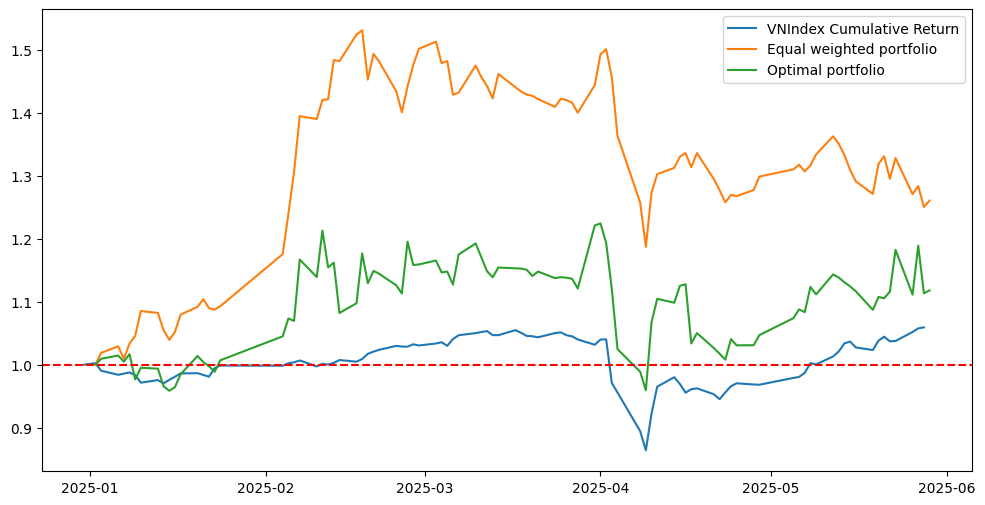

In [178]:
plt.figure(figsize=(12, 6))
plt.plot(index_return['date'], index_return['accumulative_return'], label='VNIndex Cumulative Return')
plt.plot(eq_rcm_return['date'], eq_rcm_return['accum_return'], label='Equal weighted portfolio')
plt.plot(opt_rcm_return['date'], opt_rcm_return['accum_return'], label='Optimal portfolio')
plt.legend()
plt.axhline(y=1, color='red', linestyle='--')
plt.show()